### Merge Test HRRRAK Data

Notebook contents 
* from script `./download_hrrrak_final.sh 2025 03 01` 
* the goal is to look at all the variables and figure out how to manage them 

created by Cassie Lumbrazo\
last updated: March 2025\
run location: UAS linux\
python environment: **xarray**, but now using **rasterio**

In [1]:
# import packages 
%matplotlib inline

# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_theme()
# plt.rcParams['figure.figsize'] = [12,6] #overriding size

# data packages 
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

import scipy

In [2]:
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from matplotlib import ticker

In [17]:
import rioxarray
import rasterio 

In [18]:
import cfgrib

In [3]:
pwd

'/home/cassie/python/repos/juneau_data_analysis'

The entire list of variables we should have are, 
* pressure, PRES, SP, surface 
* orography, HGT, OROG, surface
* air temperature, TMP surface, 
* relative humidity, RH 2m
* U-component wind, UGRD 10m, **not importing with the ds...*
* V-component wind, VGRD 10m, **not importing with the ds...*
* in shortwave rad, DWSRF surface 
* in longwave rad, DLWRF surface
* TMP, temperature, 2m 
* precipitation, APCP surface, **not importing with the ds...*
* precipitation, PRATE surface
* snow depth, SNOD surface
* ground temperature, TSOIL 0-0m, **this is not downloading at all as of right now**
* SWE, WEASD surface
* snow cover, SNOWC surface
* snowfall, ASNOW surface **this is not downloading at all as of right now**

In [34]:
filepath = '/home/cassie/python/download_hrrr/'
# file = 'hrrr.20250301/hrrr.t00z.wrfsfcf00.ak.grib2' # why not forcast 0? 
filename = 'hrrr.20250301/hrrr.t00z.wrfsfcf01.ak.grib2'
# filename = 'hrrr.20250301/hrrr.t00z.wrfsfcf02.ak.grib2'
# filename = 'hrrr.20250301/hrrr.t00z.wrfsfcf03.ak.grib2'

ds = cfgrib.open_datasets(filepath + filename)

# loop through for all ds
ds_list = []
for i in range(len(ds)):
    ds_list.append(ds[i])
    
ds_10m = ds_list[0].copy()
ds_2m = ds_list[1].copy()
ds_0m = ds_list[2].copy()
ds_0m = ds_0m.assign_coords({'heightAboveGround': 0.0}) 

## Merge the datasets to get all variables together

In [35]:
# drop the heightAboveGround coordinate for all three datasets 
ds_10m = ds_10m.drop('heightAboveGround')
ds_2m = ds_2m.drop('heightAboveGround')
ds_0m = ds_0m.drop('heightAboveGround')

# now merge all the datasets from ds_list...
ds = xr.merge([ds_0m, ds_2m, ds_10m]) # but height above ground is still an issue since they have different values... 
ds

/tmp/ipykernel_3912544/3283579432.py:2: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds_10m = ds_10m.drop('heightAboveGround')
/tmp/ipykernel_3912544/3283579432.py:3: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds_2m = ds_2m.drop('heightAboveGround')
/tmp/ipykernel_3912544/3283579432.py:4: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds_0m = ds_0m.drop('heightAboveGround')


<xarray.Dataset> Size: 32kB
Dimensions:     (y: 20, x: 21)
Coordinates:
    time        datetime64[ns] 8B 2025-03-01
    step        timedelta64[ns] 8B 01:00:00
    surface     float64 8B 0.0
    latitude    (y, x) float64 3kB 58.08 58.08 58.08 58.08 ... 58.59 58.59 58.59
    longitude   (y, x) float64 3kB 225.1 225.1 225.2 225.2 ... 226.0 226.0 226.1
    valid_time  datetime64[ns] 8B 2025-03-01T01:00:00
Dimensions without coordinates: y, x
Data variables: (12/15)
    unknown     (y, x) float32 2kB ...
    t           (y, x) float32 2kB ...
    sp          (y, x) float32 2kB ...
    prate       (y, x) float32 2kB ...
    sde         (y, x) float32 2kB ...
    orog        (y, x) float32 2kB ...
    ...          ...
    sdswrf      (y, x) float32 2kB ...
    sdlwrf      (y, x) float32 2kB ...
    t2m         (y, x) float32 2kB ...
    r2          (y, x) float32 2kB ...
    u10         (y, x) float32 2kB ...
    v10         (y, x) float32 2kB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP

And, get wind calculated with attributes

In [36]:
# calculate windspeed from u and v
ds['wind'] = np.sqrt(ds['u10']**2 + ds['v10']**2)
ds['wind'].attrs =  ds['u10'].attrs

ds['wind'].attrs['long_name'] = '10 metre wind speed calculated from u and v wind components'
ds['wind'].attrs['GRIB_shortName'] = '10m wind'
ds['wind'].attrs['standard_name'] = 'wind speed'
ds['wind'].attrs['GRIB_name'] = '10 metre wind speed'
ds['wind'].attrs['GRIB_cfName'] = 'wind_speed'
ds['wind'].attrs['GRIB_cfVarName'] ='wind10'
ds['wind'].attrs

{'GRIB_paramId': 165,
 'GRIB_dataType': 'fc',
 'GRIB_numberOfPoints': 420,
 'GRIB_typeOfLevel': 'heightAboveGround',
 'GRIB_stepUnits': 1,
 'GRIB_stepType': 'instant',
 'GRIB_gridType': 'polar_stereographic',
 'GRIB_NV': 0,
 'GRIB_cfName': 'wind_speed',
 'GRIB_cfVarName': 'wind10',
 'GRIB_gridDefinitionDescription': 'Polar stereographic can be south or north',
 'GRIB_missingValue': 3.4028234663852886e+38,
 'GRIB_name': '10 metre wind speed',
 'GRIB_shortName': '10m wind',
 'GRIB_units': 'm s**-1',
 'long_name': '10 metre wind speed calculated from u and v wind components',
 'units': 'm s**-1',
 'standard_name': 'wind speed'}

In [37]:
# now, let's rename a few things to make this easier 
# ds = ds.rename({'t':   'temp_0m',
#                 'sp':  'pres_0m', 
#                 't2m': 'temp_2m',
#                 'r2':  'rh_2m', 
#                 'sdwe':'swe', 
#                 'sde': 'hs',
#                 'sdswrf': 'swrad',
#                 'sdlwrf': 'lwrad',
#                 'tp': 'precip_accum',
#                 'prate': 'precip_rate',
#                 })

ds = ds.rename({'t':   'temp_surface',
                'sp':  'pressure', 
                't2m': 'temp',
                'r2':  'rh', 
                'sdwe':'swe', 
                'sde': 'snowdepth',
                'sdswrf': 'swrad',
                'sdlwrf': 'lwrad',
                'tp': 'precip_total',
                'prate': 'precip_rate',
                })

ds = ds.drop_vars('unknown')

ds

<xarray.Dataset> Size: 32kB
Dimensions:       (y: 20, x: 21)
Coordinates:
    time          datetime64[ns] 8B 2025-03-01
    step          timedelta64[ns] 8B 01:00:00
    surface       float64 8B 0.0
    latitude      (y, x) float64 3kB 58.08 58.08 58.08 ... 58.59 58.59 58.59
    longitude     (y, x) float64 3kB 225.1 225.1 225.2 ... 226.0 226.0 226.1
    valid_time    datetime64[ns] 8B 2025-03-01T01:00:00
Dimensions without coordinates: y, x
Data variables: (12/15)
    temp_surface  (y, x) float32 2kB ...
    pressure      (y, x) float32 2kB ...
    precip_rate   (y, x) float32 2kB ...
    snowdepth     (y, x) float32 2kB ...
    orog          (y, x) float32 2kB ...
    precip_total  (y, x) float32 2kB ...
    ...            ...
    lwrad         (y, x) float32 2kB ...
    temp          (y, x) float32 2kB ...
    rh            (y, x) float32 2kB ...
    u10           (y, x) float32 2kB -3.468 -1.343 -0.2181 ... 1.219 3.469
    v10           (y, x) float32 2kB 6.355 4.043 1.043 ... 2.793 0.6676 -0.2074
    wind          (y, x) float32 2kB 7.24 4.26 1.065 0.596 ... 2.936 1.39 3.476
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP

Now, it's time to try to merge multiple datetimes together... 

but first, lets deal with the coordinate reference system 

In [38]:
# check the crs of ds
ds.rio.crs

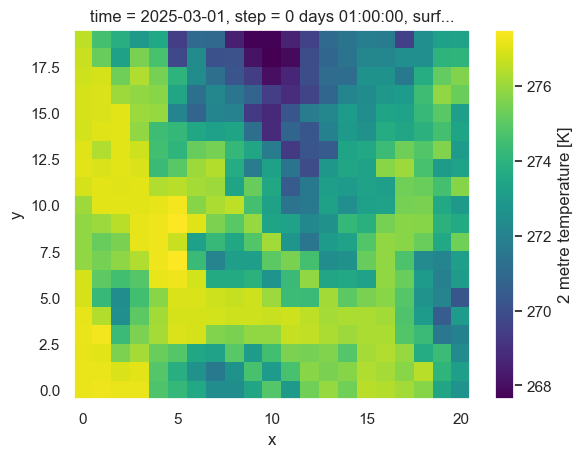

In [39]:
ds.temp.plot()

In [40]:
ds

<xarray.Dataset> Size: 32kB
Dimensions:       (y: 20, x: 21)
Coordinates:
    time          datetime64[ns] 8B 2025-03-01
    step          timedelta64[ns] 8B 01:00:00
    surface       float64 8B 0.0
    latitude      (y, x) float64 3kB 58.08 58.08 58.08 ... 58.59 58.59 58.59
    longitude     (y, x) float64 3kB 225.1 225.1 225.2 ... 226.0 226.0 226.1
    valid_time    datetime64[ns] 8B 2025-03-01T01:00:00
Dimensions without coordinates: y, x
Data variables: (12/15)
    temp_surface  (y, x) float32 2kB ...
    pressure      (y, x) float32 2kB ...
    precip_rate   (y, x) float32 2kB ...
    snowdepth     (y, x) float32 2kB ...
    orog          (y, x) float32 2kB ...
    precip_total  (y, x) float32 2kB ...
    ...            ...
    lwrad         (y, x) float32 2kB ...
    temp          (y, x) float32 2kB ...
    rh            (y, x) float32 2kB ...
    u10           (y, x) float32 2kB -3.468 -1.343 -0.2181 ... 1.219 3.469
    v10           (y, x) float32 2kB 6.355 4.043 1.043 ... 2.793 0.6676 -0.2074
    wind          (y, x) float32 2kB 7.24 4.26 1.065 0.596 ... 2.936 1.39 3.476
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP

In [41]:
# # Make sure the dataset has latitude and longitude as coordinates
# ds = ds.assign_coords({"lat": ds.latitude, "lon": ds.longitude})
# ds

In [42]:
ds.coords

Coordinates:
    time        datetime64[ns] 8B 2025-03-01
    step        timedelta64[ns] 8B 01:00:00
    surface     float64 8B 0.0
    latitude    (y, x) float64 3kB 58.08 58.08 58.08 58.08 ... 58.59 58.59 58.59
    longitude   (y, x) float64 3kB 225.1 225.1 225.2 225.2 ... 226.0 226.0 226.1
    valid_time  datetime64[ns] 8B 2025-03-01T01:00:00

In [43]:
# Assign latitude and longitude as coordinates for y and x axes
ds = ds.assign_coords({"y": ds.latitude[:, 0], "x": ds.longitude[0, :]})

# Now, check the coordinates again to make sure they are assigned properly
print(ds.coords)

Coordinates:
    time        datetime64[ns] 8B 2025-03-01
    step        timedelta64[ns] 8B 01:00:00
    surface     float64 8B 0.0
    latitude    (y, x) float64 3kB 58.08 58.08 58.08 58.08 ... 58.59 58.59 58.59
    longitude   (y, x) float64 3kB 225.1 225.1 225.2 225.2 ... 226.0 226.0 226.1
    valid_time  datetime64[ns] 8B 2025-03-01T01:00:00
  * y           (y) float64 160B 58.08 58.11 58.14 58.16 ... 58.54 58.56 58.59
  * x           (x) float64 168B 225.1 225.1 225.2 225.2 ... 226.0 226.0 226.1


In [ ]:
# Now assign the CRS with EPSG:4326 (assuming the lat/lon are in degrees)
ds.rio.write_crs("EPSG:4326", inplace=True)

# Reproject the dataset to EPSG:32608 (UTM Zone 8N)
ds_reprojected = ds.rio.reproject("EPSG:32608")

# Check the new CRS
print(ds_reprojected.rio.crs)

EPSG:32608


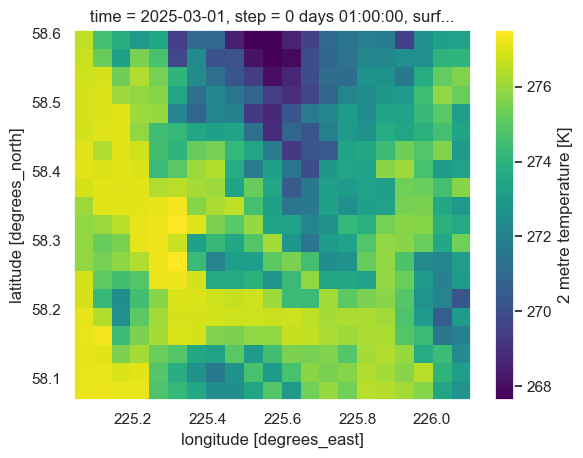

In [47]:
ds.temp.plot()

In [45]:
print(ds_reprojected.coords)

Coordinates:
  * x            (x) float64 168B 5.039e+05 5.069e+05 ... 5.603e+05 5.633e+05
  * y            (y) float64 160B 6.495e+06 6.492e+06 ... 6.442e+06 6.439e+06
    latitude     (y, x) float64 3kB 58.08 58.08 58.08 ... 58.59 58.59 58.59
    time         datetime64[ns] 8B 2025-03-01
    surface      float64 8B 0.0
    longitude    (y, x) float64 3kB 225.1 225.1 225.2 ... 226.0 226.0 226.1
    valid_time   datetime64[ns] 8B 2025-03-01T01:00:00
    step         timedelta64[ns] 8B 01:00:00
    spatial_ref  int64 8B 0


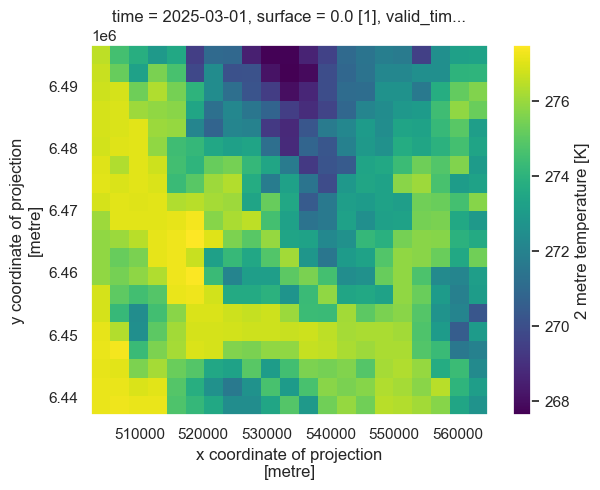

In [46]:
ds_reprojected.temp.plot()

Not sure what to do with this reprojected value.. but the other ds looks good 

### Let's select a single gridcell by latitude and longitude 

In [49]:
# Powder Patch Lat/Lon
lat_powderpatch = 58.26200
lon_powderpatch = -134.51700
elevation_powderpatch = 2198 # feet 

# select the nearest grid point to the given lat/lon
# Note: method='nearest' will find the nearest grid point
ds_powderpatch = ds.sel(y=lat_powderpatch, x=lon_powderpatch, method='nearest')
ds_powderpatch

<xarray.Dataset> Size: 132B
Dimensions:       ()
Coordinates:
    time          datetime64[ns] 8B 2025-03-01
    step          timedelta64[ns] 8B 01:00:00
    surface       float64 8B 0.0
    latitude      float64 8B 58.27
    longitude     float64 8B 225.1
    valid_time    datetime64[ns] 8B 2025-03-01T01:00:00
    y             float64 8B 58.27
    x             float64 8B 225.1
    spatial_ref   int64 8B 0
Data variables: (12/15)
    temp_surface  float32 4B 275.7
    pressure      float32 4B 1.003e+05
    precip_rate   float32 4B 0.00042
    snowdepth     float32 4B 2.242
    orog          float32 4B 62.96
    precip_total  float32 4B 2.031
    ...            ...
    lwrad         float32 4B 318.5
    temp          float32 4B 275.9
    rh            float32 4B 92.4
    u10           float32 4B -2.968
    v10           float32 4B 0.2926
    wind          float32 4B 2.982
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP

In [52]:
ds_powderpatch.temp

<xarray.DataArray 'temp' ()> Size: 4B
array(275.87964, dtype=float32)
Coordinates:
    time         datetime64[ns] 8B 2025-03-01
    step         timedelta64[ns] 8B 01:00:00
    surface      float64 8B 0.0
    latitude     float64 8B 58.27
    longitude    float64 8B 225.1
    valid_time   datetime64[ns] 8B 2025-03-01T01:00:00
    y            float64 8B 58.27
    x            float64 8B 225.1
    spatial_ref  int64 8B 0
Attributes: (12/18)
    GRIB_paramId:                    167
    GRIB_dataType:                   fc
    GRIB_numberOfPoints:             420
    GRIB_typeOfLevel:                heightAboveGround
    GRIB_stepUnits:                  1
    GRIB_stepType:                   instant
    ...                              ...
    GRIB_name:                       2 metre temperature
    GRIB_shortName:                  2t
    GRIB_units:                      K
    long_name:                       2 metre temperature
    units:                           K
    standard_name:                   air_temperature

### Okay, that worked. Now, we need to figure out how to create a timeseries from multiple grib files, then we can select Powder Patch from that timeseries to compare with meteorological variables

In [54]:
filepath = '/home/cassie/python/download_hrrr/'
filename01 = 'hrrr.20250301/hrrr.t00z.wrfsfcf01.ak.grib2'
filename02 = 'hrrr.20250301/hrrr.t00z.wrfsfcf02.ak.grib2'
filename03 = 'hrrr.20250301/hrrr.t00z.wrfsfcf03.ak.grib2'

ds = cfgrib.open_datasets(filepath + filename01)

# loop through for all ds
ds_list = []
for i in range(len(ds)):
    ds_list.append(ds[i])
    
ds_10m = ds_list[0].copy()
ds_2m = ds_list[1].copy()
ds_0m = ds_list[2].copy()
ds_0m = ds_0m.assign_coords({'heightAboveGround': 0.0}) 

# drop the heightAboveGround coordinate for all three datasets 
ds_10m = ds_10m.drop('heightAboveGround')
ds_2m = ds_2m.drop('heightAboveGround')
ds_0m = ds_0m.drop('heightAboveGround')

# now merge all the datasets from ds_list...
ds = xr.merge([ds_0m, ds_2m, ds_10m]) # but height above ground is still an issue since they have different values... 

# calculate windspeed from u and v
ds['wind'] = np.sqrt(ds['u10']**2 + ds['v10']**2)
ds['wind'].attrs =  ds['u10'].attrs

ds['wind'].attrs['long_name'] = '10 metre wind speed calculated from u and v wind components'
ds['wind'].attrs['GRIB_shortName'] = '10m wind'
ds['wind'].attrs['standard_name'] = 'wind speed'
ds['wind'].attrs['GRIB_name'] = '10 metre wind speed'
ds['wind'].attrs['GRIB_cfName'] = 'wind_speed'
ds['wind'].attrs['GRIB_cfVarName'] ='wind10'
ds['wind'].attrs

# 
ds = ds.rename({'t':   'temp_surface',
                'sp':  'pressure', 
                't2m': 'temp',
                'r2':  'rh', 
                'sdwe':'swe', 
                'sde': 'snowdepth',
                'sdswrf': 'swrad',
                'sdlwrf': 'lwrad',
                'tp': 'precip_total',
                'prate': 'precip_rate',
                })

ds = ds.drop_vars('unknown')
ds

/tmp/ipykernel_3912544/3089135548.py:19: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds_10m = ds_10m.drop('heightAboveGround')
/tmp/ipykernel_3912544/3089135548.py:20: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds_2m = ds_2m.drop('heightAboveGround')
/tmp/ipykernel_3912544/3089135548.py:21: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds_0m = ds_0m.drop('heightAboveGround')


<xarray.Dataset> Size: 32kB
Dimensions:       (y: 20, x: 21)
Coordinates:
    time          datetime64[ns] 8B 2025-03-01
    step          timedelta64[ns] 8B 01:00:00
    surface       float64 8B 0.0
    latitude      (y, x) float64 3kB 58.08 58.08 58.08 ... 58.59 58.59 58.59
    longitude     (y, x) float64 3kB 225.1 225.1 225.2 ... 226.0 226.0 226.1
    valid_time    datetime64[ns] 8B 2025-03-01T01:00:00
Dimensions without coordinates: y, x
Data variables: (12/15)
    temp_surface  (y, x) float32 2kB ...
    pressure      (y, x) float32 2kB ...
    precip_rate   (y, x) float32 2kB ...
    snowdepth     (y, x) float32 2kB ...
    orog          (y, x) float32 2kB ...
    precip_total  (y, x) float32 2kB ...
    ...            ...
    lwrad         (y, x) float32 2kB ...
    temp          (y, x) float32 2kB ...
    rh            (y, x) float32 2kB ...
    u10           (y, x) float32 2kB -3.468 -1.343 -0.2181 ... 1.219 3.469
    v10           (y, x) float32 2kB 6.355 4.043 1.043 ... 2.793 0.6676 -0.2074
    wind          (y, x) float32 2kB 7.24 4.26 1.065 0.596 ... 2.936 1.39 3.476
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP

Okay, that's the previous block of code I would use. 

In [87]:
# Define filepaths
filepath = '/home/cassie/python/download_hrrr/'
filename01 = 'hrrr.20250301/hrrr.t00z.wrfsfcf01.ak.grib2'
filename02 = 'hrrr.20250301/hrrr.t00z.wrfsfcf02.ak.grib2'
filename03 = 'hrrr.20250301/hrrr.t00z.wrfsfcf03.ak.grib2'

# List of filenames
filenames = [filename01, filename02, filename03]

# Initialize an empty list to store processed datasets
ds_list = []

# Process each file
for filename in filenames:
    ds = cfgrib.open_datasets(filepath + filename)
    
    # Process the individual dataset, similar to what you've already done
    ds_10m = ds[0].copy()  # Assuming first dataset has u10, v10 (for wind)
    ds_2m = ds[1].copy()   # Assuming second dataset has temp, rh, etc.
    ds_0m = ds[2].copy()   # Assuming third dataset has other variables
    
    # Make necessary adjustments, such as heightAboveGround
    ds_0m = ds_0m.assign_coords({'heightAboveGround': 0.0})
    
    # Drop heightAboveGround for all datasets
    ds_10m = ds_10m.drop('heightAboveGround')
    ds_2m = ds_2m.drop('heightAboveGround')
    ds_0m = ds_0m.drop('heightAboveGround')
    
    # Merge the datasets into one dataset
    ds_temp = xr.merge([ds_0m, ds_2m, ds_10m])
    
    # Calculate windspeed from u10 and v10 (10m wind)
    ds_temp['wind'] = np.sqrt(ds_temp['u10']**2 + ds_temp['v10']**2)
    ds_temp['wind'].attrs = ds_temp['u10'].attrs
    ds_temp['wind'].attrs['long_name'] = '10 metre wind speed calculated from u and v wind components'
    ds_temp['wind'].attrs['GRIB_shortName'] = '10m wind'
    ds_temp['wind'].attrs['standard_name'] = 'wind speed'
    ds_temp['wind'].attrs['GRIB_name'] = '10 metre wind speed'
    ds_temp['wind'].attrs['GRIB_cfName'] = 'wind_speed'
    ds_temp['wind'].attrs['GRIB_cfVarName'] = 'wind10'
    
    # Rename variables for consistency
    ds_temp = ds_temp.rename({
        't': 'temp_surface',
        'sp': 'pressure', 
        't2m': 'temp',
        'r2': 'rh', 
        'sdwe': 'swe', 
        'sde': 'snowdepth',
        'sdswrf': 'swrad',
        'sdlwrf': 'lwrad',
        'tp': 'precip_total',
        'prate': 'precip_rate'
    })
    
    # Drop any unknown variables
    ds_temp = ds_temp.drop_vars('unknown')
    
    # Append the processed dataset to the list
    ds_list.append(ds_temp)

# Concatenate datasets along the time dimension
# The time coordinate in each dataset should be unique; if not, you might want to adjust it.
ds_combined = xr.concat(ds_list, dim='time')

# You should now have a timeseries dataset with multiple time steps
ds_combined

/tmp/ipykernel_3912544/1984012103.py:26: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds_10m = ds_10m.drop('heightAboveGround')
/tmp/ipykernel_3912544/1984012103.py:27: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds_2m = ds_2m.drop('heightAboveGround')
/tmp/ipykernel_3912544/1984012103.py:28: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds_0m = ds_0m.drop('heightAboveGround')
/tmp/ipykernel_3912544/1984012103.py:26: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds_10m = ds_10m.drop('heightAboveGround')
/tmp/ipykernel_3912544/1984012103.py:27: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds_2m = ds_2m.drop('heightAboveGround')
/tmp/ipykernel_3912544/1984012103.py:28: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds_0m = ds_0m.drop('heightAboveGround')
/tmp/i

<xarray.Dataset> Size: 82kB
Dimensions:       (time: 3, y: 20, x: 21)
Coordinates:
  * time          (time) datetime64[ns] 24B 2025-03-01 2025-03-01 2025-03-01
    step          (time) timedelta64[ns] 24B 01:00:00 02:00:00 03:00:00
    surface       float64 8B 0.0
    latitude      (y, x) float64 3kB 58.08 58.08 58.08 ... 58.59 58.59 58.59
    longitude     (y, x) float64 3kB 225.1 225.1 225.2 ... 226.0 226.0 226.1
    valid_time    (time) datetime64[ns] 24B 2025-03-01T01:00:00 ... 2025-03-0...
Dimensions without coordinates: y, x
Data variables: (12/15)
    temp_surface  (time, y, x) float32 5kB 277.3 277.2 277.2 ... 272.7 273.1
    pressure      (time, y, x) float32 5kB 1.01e+05 1.01e+05 ... 9.415e+04
    precip_rate   (time, y, x) float32 5kB 0.00028 0.00024 ... 0.00045 0.00045
    snowdepth     (time, y, x) float32 5kB 0.0 0.0 0.0 0.0 ... 29.24 24.93 23.76
    orog          (time, y, x) float32 5kB -0.01151 -0.01151 ... 712.3 580.0
    precip_total  (time, y, x) float32 5kB 1.746 1.506 1.412 ... 4.92 4.571
    ...            ...
    lwrad         (time, y, x) float32 5kB 316.7 322.0 324.0 ... 306.9 308.4
    temp          (time, y, x) float32 5kB 277.2 277.3 277.2 ... 272.8 273.4
    rh            (time, y, x) float32 5kB 91.2 90.9 92.4 ... 93.8 95.0 94.6
    u10           (time, y, x) float32 5kB -3.468 -1.343 ... -0.1717 3.766
    v10           (time, y, x) float32 5kB 6.355 4.043 1.043 ... -0.7666 -1.142
    wind          (time, y, x) float32 5kB 7.24 4.26 1.065 ... 0.7856 3.935
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP

In [88]:
ds_combined

<xarray.Dataset> Size: 82kB
Dimensions:       (time: 3, y: 20, x: 21)
Coordinates:
  * time          (time) datetime64[ns] 24B 2025-03-01 2025-03-01 2025-03-01
    step          (time) timedelta64[ns] 24B 01:00:00 02:00:00 03:00:00
    surface       float64 8B 0.0
    latitude      (y, x) float64 3kB 58.08 58.08 58.08 ... 58.59 58.59 58.59
    longitude     (y, x) float64 3kB 225.1 225.1 225.2 ... 226.0 226.0 226.1
    valid_time    (time) datetime64[ns] 24B 2025-03-01T01:00:00 ... 2025-03-0...
Dimensions without coordinates: y, x
Data variables: (12/15)
    temp_surface  (time, y, x) float32 5kB 277.3 277.2 277.2 ... 272.7 273.1
    pressure      (time, y, x) float32 5kB 1.01e+05 1.01e+05 ... 9.415e+04
    precip_rate   (time, y, x) float32 5kB 0.00028 0.00024 ... 0.00045 0.00045
    snowdepth     (time, y, x) float32 5kB 0.0 0.0 0.0 0.0 ... 29.24 24.93 23.76
    orog          (time, y, x) float32 5kB -0.01151 -0.01151 ... 712.3 580.0
    precip_total  (time, y, x) float32 5kB 1.746 1.506 1.412 ... 4.92 4.571
    ...            ...
    lwrad         (time, y, x) float32 5kB 316.7 322.0 324.0 ... 306.9 308.4
    temp          (time, y, x) float32 5kB 277.2 277.3 277.2 ... 272.8 273.4
    rh            (time, y, x) float32 5kB 91.2 90.9 92.4 ... 93.8 95.0 94.6
    u10           (time, y, x) float32 5kB -3.468 -1.343 ... -0.1717 3.766
    v10           (time, y, x) float32 5kB 6.355 4.043 1.043 ... -0.7666 -1.142
    wind          (time, y, x) float32 5kB 7.24 4.26 1.065 ... 0.7856 3.935
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP

In [89]:
ds_combined.valid_time

<xarray.DataArray 'valid_time' (time: 3)> Size: 24B
array(['2025-03-01T01:00:00.000000000', '2025-03-01T02:00:00.000000000',
       '2025-03-01T03:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time        (time) datetime64[ns] 24B 2025-03-01 2025-03-01 2025-03-01
    step        (time) timedelta64[ns] 24B 01:00:00 02:00:00 03:00:00
    surface     float64 8B 0.0
    valid_time  (time) datetime64[ns] 24B 2025-03-01T01:00:00 ... 2025-03-01T...
Attributes:
    standard_name:  time
    long_name:      time

Create a datetime coordinate from the valid_time coordinate which is tidy in case I need it later...

In [86]:
# # ds_combined['datetime'] = ds_combined['valid_time'].values.astype('datetime64[s]') # let's also leave this as a variable for plotting??? 
# # ds_combined['datetime_var'] = ds_combined['valid_time'].dt.strftime('%Y-%m-%d %H:%M:%S') # now sure if this is better?? 

# # Convert 'valid_time' to 'datetime64[s]' (second precision, no nanoseconds)
# cleaned_valid_time = ds_combined['valid_time'].values.astype('datetime64[s]')

# # Assign the cleaned 'valid_time' as a new coordinate called 'datetime'
# ds_combined = ds_combined.assign_coords(datetime=('valid_time', cleaned_valid_time))

# # Check the result
# ds_combined

(array([ 19.,  27.,  48.,  69., 102., 215., 191., 192., 192., 205.]),
 array([267.00933838, 268.05886841, 269.10839844, 270.15792847,
        271.2074585 , 272.25698853, 273.30651855, 274.35604858,
        275.40557861, 276.45510864, 277.50463867]),
 <BarContainer object of 10 artists>)

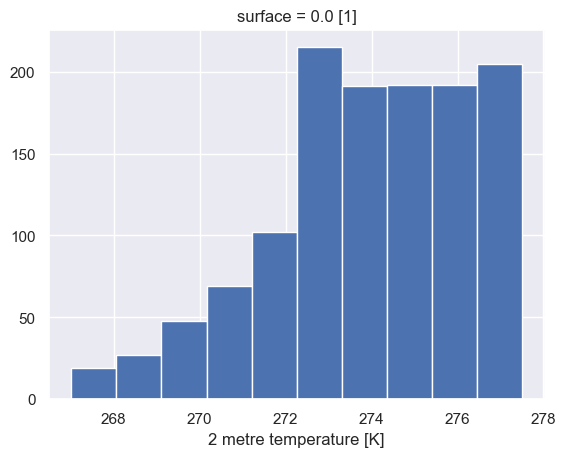

In [90]:
ds_combined.temp.plot()

In [92]:
ds_combined

<xarray.Dataset> Size: 82kB
Dimensions:       (time: 3, y: 20, x: 21)
Coordinates:
  * time          (time) datetime64[ns] 24B 2025-03-01 2025-03-01 2025-03-01
    step          (time) timedelta64[ns] 24B 01:00:00 02:00:00 03:00:00
    surface       float64 8B 0.0
    latitude      (y, x) float64 3kB 58.08 58.08 58.08 ... 58.59 58.59 58.59
    longitude     (y, x) float64 3kB 225.1 225.1 225.2 ... 226.0 226.0 226.1
    valid_time    (time) datetime64[ns] 24B 2025-03-01T01:00:00 ... 2025-03-0...
Dimensions without coordinates: y, x
Data variables: (12/15)
    temp_surface  (time, y, x) float32 5kB 277.3 277.2 277.2 ... 272.7 273.1
    pressure      (time, y, x) float32 5kB 1.01e+05 1.01e+05 ... 9.415e+04
    precip_rate   (time, y, x) float32 5kB 0.00028 0.00024 ... 0.00045 0.00045
    snowdepth     (time, y, x) float32 5kB 0.0 0.0 0.0 0.0 ... 29.24 24.93 23.76
    orog          (time, y, x) float32 5kB -0.01151 -0.01151 ... 712.3 580.0
    precip_total  (time, y, x) float32 5kB 1.746 1.506 1.412 ... 4.92 4.571
    ...            ...
    lwrad         (time, y, x) float32 5kB 316.7 322.0 324.0 ... 306.9 308.4
    temp          (time, y, x) float32 5kB 277.2 277.3 277.2 ... 272.8 273.4
    rh            (time, y, x) float32 5kB 91.2 90.9 92.4 ... 93.8 95.0 94.6
    u10           (time, y, x) float32 5kB -3.468 -1.343 ... -0.1717 3.766
    v10           (time, y, x) float32 5kB 6.355 4.043 1.043 ... -0.7666 -1.142
    wind          (time, y, x) float32 5kB 7.24 4.26 1.065 ... 0.7856 3.935
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP

In [96]:
ds_combined.rio.crs

First, we need to set the crs again 

In [ ]:
# Assign latitude and longitude as coordinates for y and x axes
ds_combined = ds_combined.assign_coords({"y": ds_combined.latitude[:, 0], "x": ds_combined.longitude[0, :]})

# Now, check the coordinates again to make sure they are assigned properly
print(ds_combined.coords)

# Now assign the CRS with EPSG:4326 (assuming the lat/lon are in degrees)
ds_combined.rio.write_crs("EPSG:4326", inplace=True)

ds_combined.rio.crs

Coordinates:
  * time        (time) datetime64[ns] 24B 2025-03-01 2025-03-01 2025-03-01
    step        (time) timedelta64[ns] 24B 01:00:00 02:00:00 03:00:00
    surface     float64 8B 0.0
    latitude    (y, x) float64 3kB 58.08 58.08 58.08 58.08 ... 58.59 58.59 58.59
    longitude   (y, x) float64 3kB 225.1 225.1 225.2 225.2 ... 226.0 226.0 226.1
    valid_time  (time) datetime64[ns] 24B 2025-03-01T01:00:00 ... 2025-03-01T...
  * y           (y) float64 160B 58.08 58.11 58.14 58.16 ... 58.54 58.56 58.59
  * x           (x) float64 168B 225.1 225.1 225.2 225.2 ... 226.0 226.0 226.1


CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]')

In [ ]:
# Powder Patch Lat/Lon
lat_powderpatch = 58.26200
lon_powderpatch = -134.51700
elevation_powderpatch = 2198 # feet 

# select the nearest grid point to the given lat/lon
ds_combined_pp = ds_combined.sel(y=lat_powderpatch, x=lon_powderpatch, method='nearest') 

In [99]:
ds_combined_pp

<xarray.Dataset> Size: 300B
Dimensions:       (time: 3)
Coordinates:
  * time          (time) datetime64[ns] 24B 2025-03-01 2025-03-01 2025-03-01
    step          (time) timedelta64[ns] 24B 01:00:00 02:00:00 03:00:00
    surface       float64 8B 0.0
    latitude      float64 8B 58.27
    longitude     float64 8B 225.1
    valid_time    (time) datetime64[ns] 24B 2025-03-01T01:00:00 ... 2025-03-0...
    y             float64 8B 58.27
    x             float64 8B 225.1
    spatial_ref   int64 8B 0
Data variables: (12/15)
    temp_surface  (time) float32 12B 275.7 274.9 274.5
    pressure      (time) float32 12B 1.003e+05 1.003e+05 1.003e+05
    precip_rate   (time) float32 12B 0.00042 0.00041 0.00048
    snowdepth     (time) float32 12B 2.242 2.241 2.241
    orog          (time) float32 12B 62.96 62.96 62.96
    precip_total  (time) float32 12B 2.031 3.333 4.95
    ...            ...
    lwrad         (time) float32 12B 318.5 318.7 319.3
    temp          (time) float32 12B 275.9 275.4 274.9
    rh            (time) float32 12B 92.4 91.7 91.9
    u10           (time) float32 12B -2.968 -2.192 -2.922
    v10           (time) float32 12B 0.2926 0.3792 -0.3291
    wind          (time) float32 12B 2.982 2.224 2.94
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP

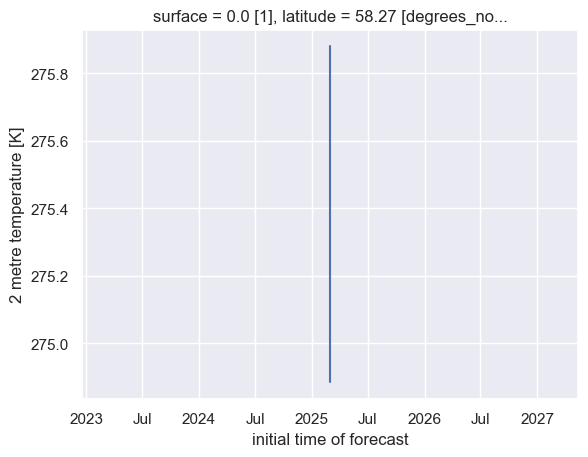

In [100]:
ds_combined_pp.temp.plot()

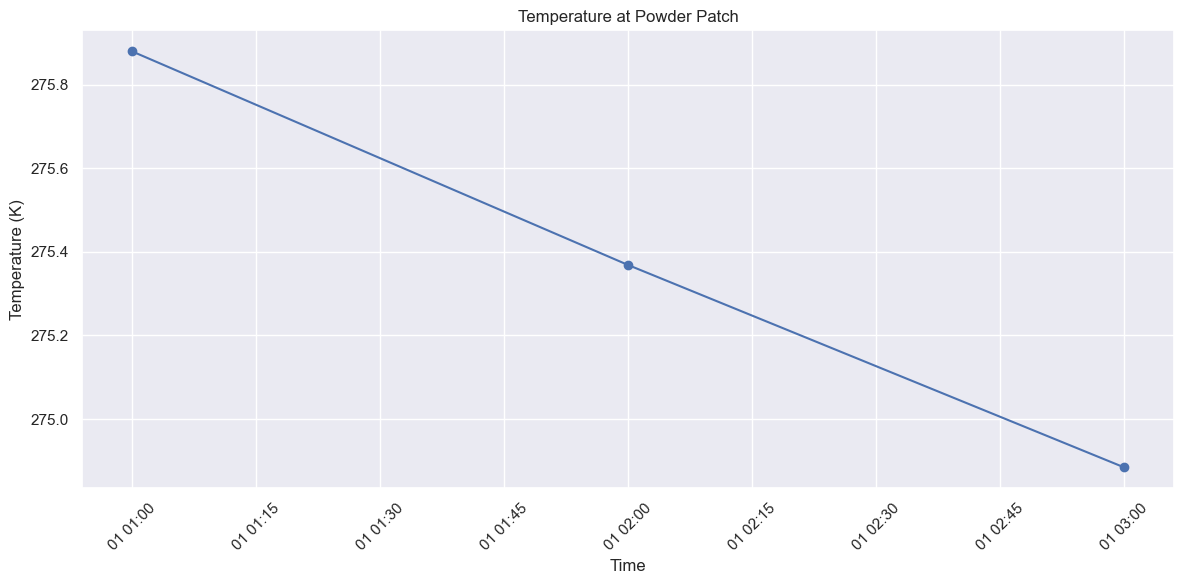

In [101]:
# ds_combined_pp.temp.plot()
# zoom in the xaxis to see the time series better
plt.figure(figsize=(12, 6))
plt.plot(ds_combined_pp['valid_time'].values, ds_combined_pp['temp'].values, marker='o', linestyle='-', color='b')
plt.title('Temperature at Powder Patch')
plt.xlabel('Time')
plt.ylabel('Temperature (K)')
plt.xticks(rotation=45)
# plt.grid(True)
plt.tight_layout()
plt.show()

ValueError: x and y can be no greater than 2D, but have shapes (3,) and (3, 20, 21)

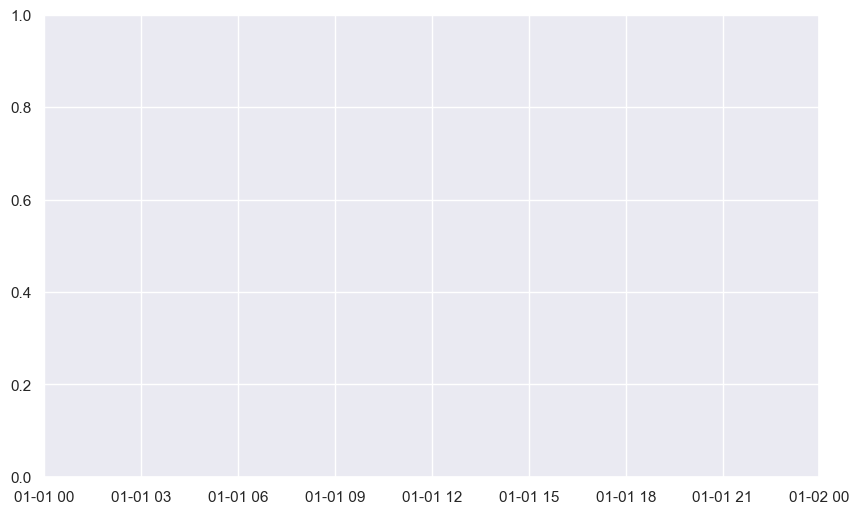

In [84]:
# Plot the 'temp' variable as a time series
plt.figure(figsize=(10, 6))

# Plot 'temp' over time (using the 'datetime' coordinate)
plt.plot(ds_combined['datetime'].values, ds_combined['temp'].values, marker='o', label='Temperature')

# Add labels and title
plt.xlabel('Datetime')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Time Series')

# Add a legend
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()